In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display, Image
from ipywidgets import widgets, interact
from scipy.ndimage import gaussian_filter, find_objects
from copy import deepcopy
from glob import glob
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
from hagelslag.processing.EnhancedWatershedSegmenter import EnhancedWatershed, rescale_data
from hagelslag.processing.Watershed import Watershed
from hagelslag.processing.Hysteresis import Hysteresis
from hagelslag.data.ModelOutput import ModelOutput
from hagelslag.processing.ObjectMatcher import ObjectMatcher, shifted_centroid_distance, centroid_distance
from hagelslag.processing.STObject import STObject
from matplotlib.colors import ListedColormap
from hagelslag.processing.tracker import label_storm_objects, extract_storm_objects
from scipy.ndimage import label, maximum, find_objects
from skimage.morphology import watershed

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
model_path = "../testdata/spring2015_unidata/"
ensemble_name = "SSEF"
member ="wrf-s3cn_arw"
run_date = datetime(2015, 6, 4)
# We will be using the uh_max (hourly max 2-5 km Updraft Helicity) variable for this exercise
# cmpref (simulated composite radar reflectivity) is also available.
variable = "cmpref"
start_date = run_date + timedelta(hours=22)
end_date = run_date + timedelta(hours=22)
model_grid = ModelOutput(ensemble_name, 
                         member, 
                         run_date, 
                         variable, 
                         start_date, 
                         end_date,
                         model_path,
                         map_file="../mapfiles/ssef2015.map",
                         single_step=False)
model_grid.load_data()
model_grid.load_map_info("../mapfiles/ssef2015.map")
data = model_grid.data[0]

In [11]:
model_grid.data.shape

(1, 1155, 1683)

Here is a radar image we want to identify storm objects in. It has a mix of broad precip, weak, convection, and a couple of supercells.

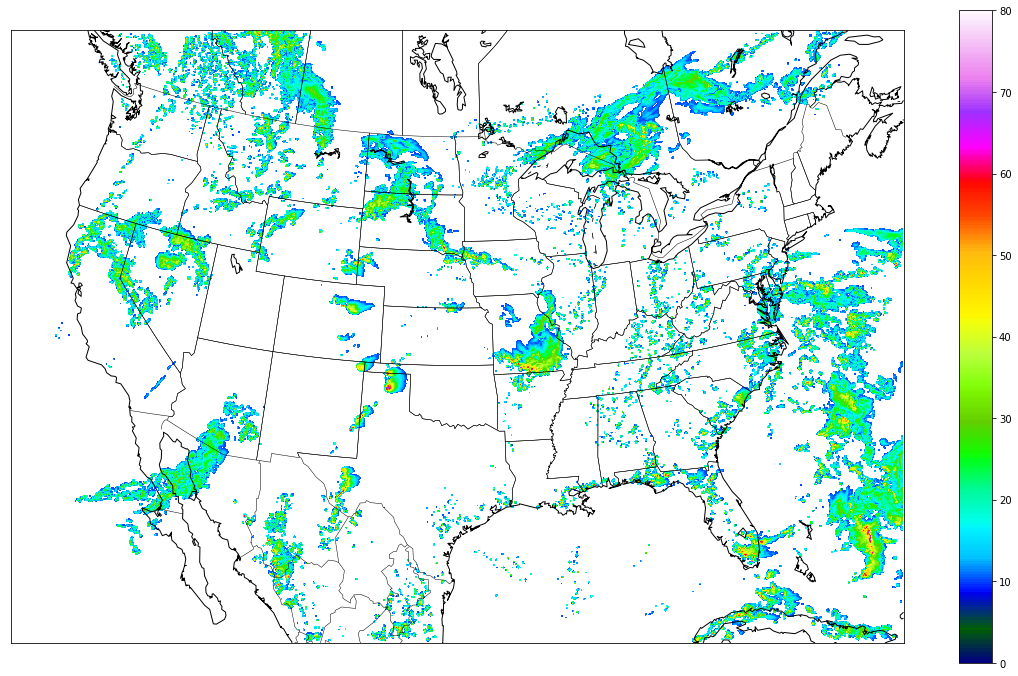

In [7]:
plt.figure(figsize=(20, 12))
bmap = Basemap(projection="lcc", lat_0=38.5, lon_0=-97, lat_1=30, lat_2=60, rsphere=6370000,
               llcrnrlon=model_grid.lon[0,0], resolution='l',
               llcrnrlat=model_grid.lat[0,0],urcrnrlon=model_grid.lon[-1, -1], urcrnrlat=model_grid.lat[-1, -1])
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
x, y = bmap(model_grid.lon, model_grid.lat)
plt.pcolormesh(x, y, np.ma.array(model_grid.data[0], mask=model_grid.data[0] < 10), vmin=0, vmax=80, cmap="gist_ncar")
plt.colorbar()
plt.savefig("radar_example.png", dpi=200, bbox_inches="tight")

We will rescale the data for the watershed later.

Let's try hysteresis first, which does a labeling at a high threshold then grows the objects until the lower intensity threshold is reached.

In [8]:
hyst = Hysteresis(20, 40)
h_labels = hyst.label(gaussian_filter(data, 1))

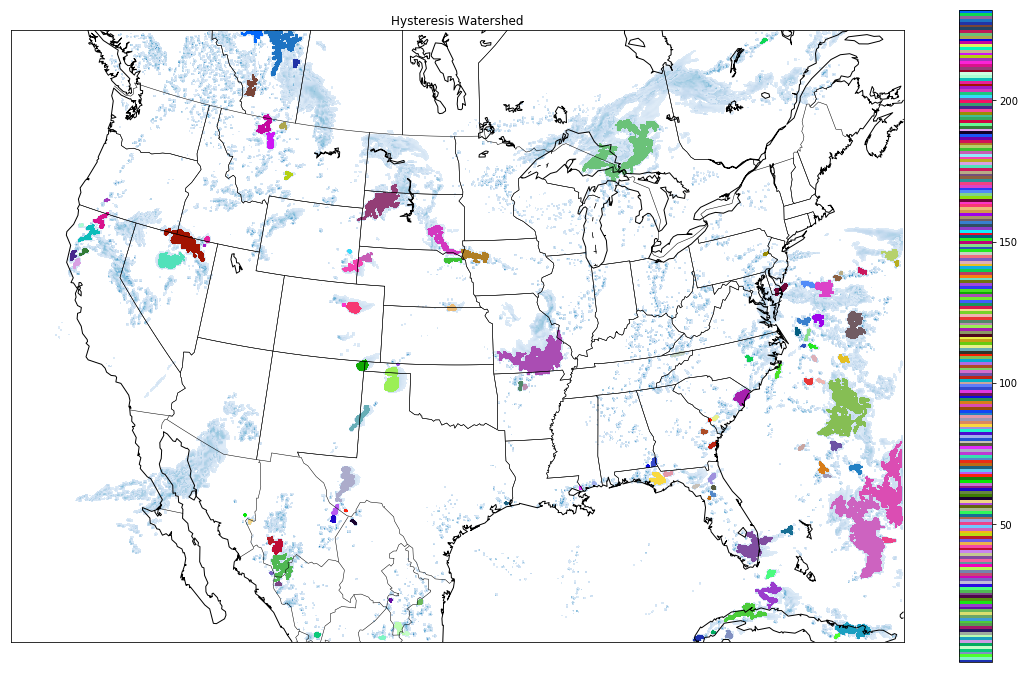

In [9]:
plt.figure(figsize=(20, 12))
cm = ListedColormap(np.random.random(size=(h_labels.max(), 3)).tolist())
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
pc = plt.pcolormesh(x, y, np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(x, y, np.ma.array(h_labels, mask=h_labels <= 0), cmap=cm)
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.title("Hysteresis Watershed")
plt.savefig("hyst_out.png", dpi=200, bbox_inches="tight")

Compare with scipy.ndimage.label

In [10]:
s_labels = label(gaussian_filter(data, 1) > 20)[0]

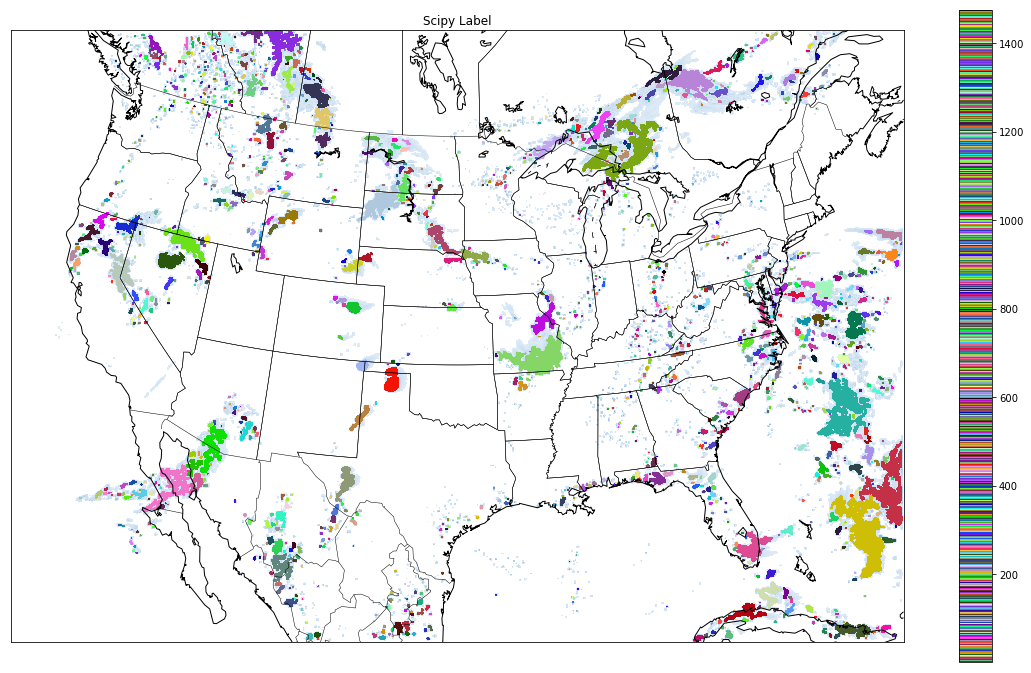

In [11]:
plt.figure(figsize=(20, 12))
cm = ListedColormap(np.random.random(size=(s_labels.max(), 3)).tolist())
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
pc = plt.pcolormesh(x, y, np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(x, y, np.ma.array(s_labels, mask=s_labels <= 0), cmap=cm)
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.title("Scipy Label")
plt.savefig("ndlabel_out.png", dpi=200, bbox_inches="tight")

In [12]:
s_labels_40 = label(gaussian_filter(data, 1) > 40)[0]

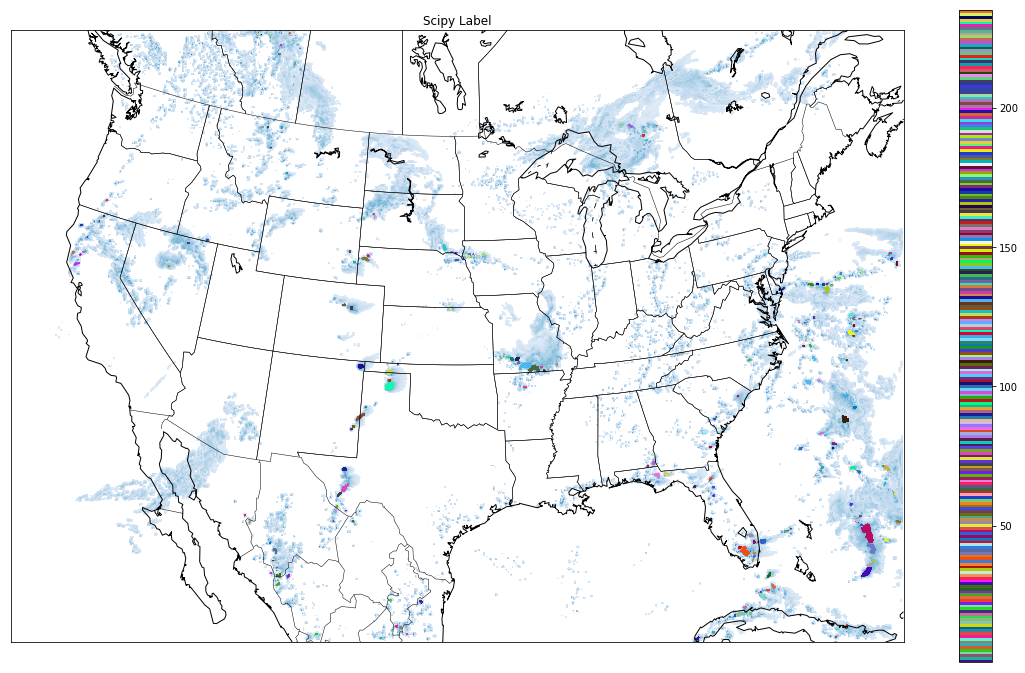

In [13]:
plt.figure(figsize=(20, 12))
cm = ListedColormap(np.random.random(size=(s_labels_40.max(), 3)).tolist())
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
pc = plt.pcolormesh(x, y, np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(x, y, np.ma.array(s_labels_40, mask=s_labels_40 <= 0), cmap=cm)
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.title("Scipy Label")
plt.savefig("ndlabel_40_out.png", dpi=200, bbox_inches="tight")

This one is for the regular watershed, which uses the above labeling to start and then grows out the regions with the watershed transform.

In [14]:
ws = Watershed(20, 40)
ws_labels = ws.label(gaussian_filter(data,1))


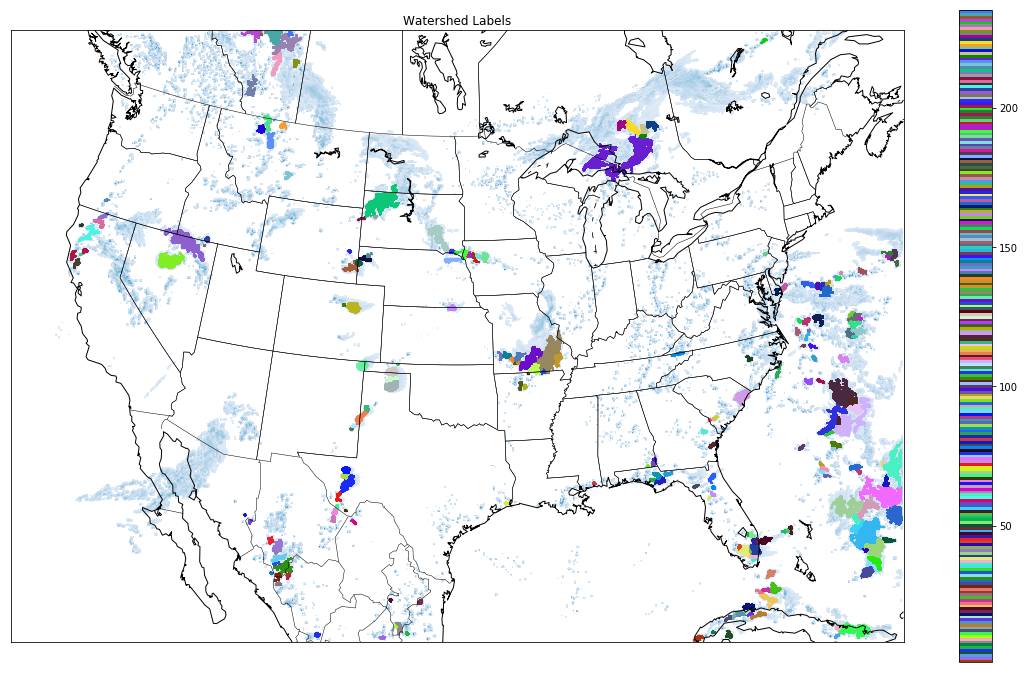

In [15]:
plt.figure(figsize=(20, 12))
cm = ListedColormap(np.random.random(size=(ws_labels.max(), 3)).tolist())
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
pc = plt.pcolormesh(x, y, np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(x, y, np.ma.array(ws_labels, mask=ws_labels <= 0), cmap=cm)
plt.title("Watershed Labels")
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.savefig("ws_out.png", dpi=200, bbox_inches="tight")

The enhanced watershed grows regions out with an area constraint and no constraint on local maxima for starting points.

In [13]:
scaled_data = rescale_data(data, 20, data.max(), 0, 100)
ew = EnhancedWatershed(0, 10, 100, 200, 1)
ew_labels = ew.label(gaussian_filter(scaled_data, 1))

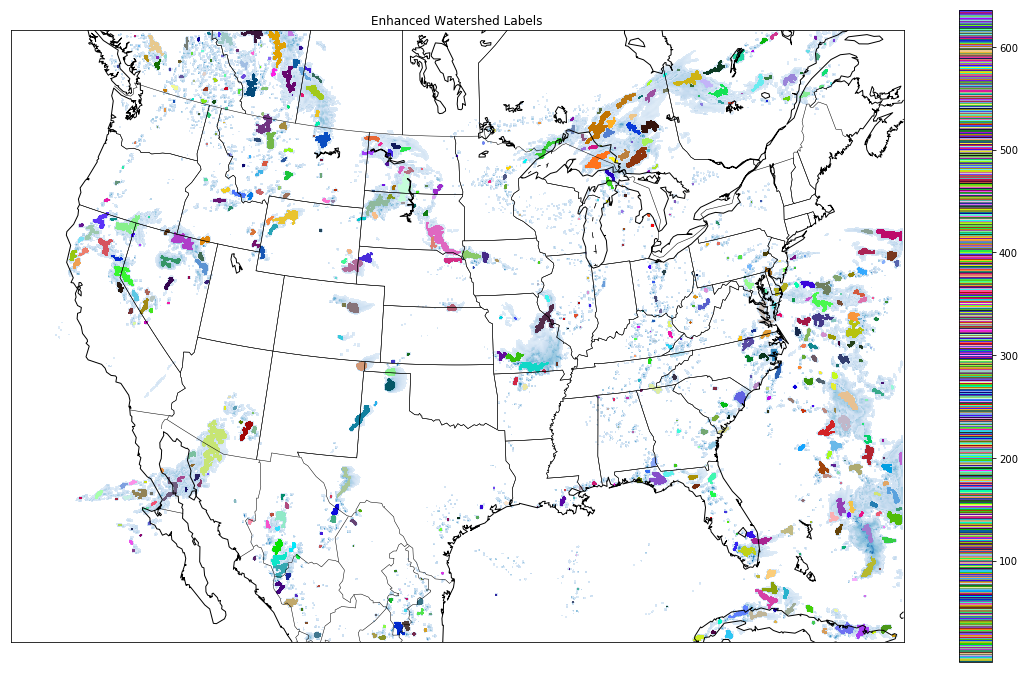

In [14]:
plt.figure(figsize=(20, 12))
cm = ListedColormap(np.random.random(size=(ew_labels.max(), 3)).tolist())
bmap.drawcoastlines()
bmap.drawstates()
bmap.drawcountries()
pc = plt.pcolormesh(x, y, np.ma.array(data, mask=data<10), vmin=0, vmax=80, cmap="Blues")
plt.pcolormesh(x, y, np.ma.array(ew_labels, mask=ew_labels <= 0), cmap=cm)
plt.title("Enhanced Watershed Labels")
#plt.xlim(200, 400)
#plt.ylim(200, 500)
plt.colorbar()
plt.savefig("ew_out.png", dpi=200, bbox_inches="tight")

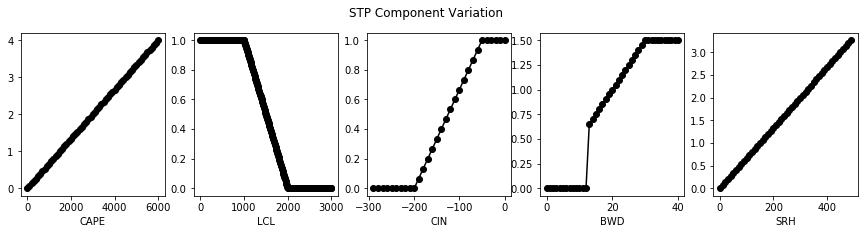

In [141]:
cape_values = np.arange(0, 6100, 100)
sbLCL_values = np.arange(0, 3010, 10)
srh_values = np.arange(0, 500, 10)
bwd_values = np.arange(0, 41)
sbcin_values = np.arange(0, -300, -10)
def lcl_transform(lcl):
    lclt = (2000 - lcl) / 1000
    lclt[lcl < 1000] = 1
    lclt[lcl > 2000] = 0
    return lclt

def cin_transform(cin):
    cint = (200 + cin) / 150
    cint[cin > -50] = 1
    cint[cin < -200] = 0
    return cint

def bwd_transform(bwd):
    bwdt = bwd / 20
    bwdt[bwd < 12.5] = 0
    bwdt[bwd > 30] = 1.5
    return bwdt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes[0].plot(cape_values, cape_values / 1500, 'ko-')
axes[1].plot(sbLCL_values, lcl_transform(sbLCL_values), 'ko-')
axes[2].plot(sbcin_values, cin_transform(sbcin_values), 'ko-')
axes[3].plot(bwd_values, bwd_transform(bwd_values), 'ko-')
axes[4].plot(srh_values, srh_values / 150, 'ko-')
titles = ["CAPE", "LCL", "CIN", "BWD", "SRH"]
for a in range(5):
    axes[a].set_xlabel(titles[a])
fig.suptitle("STP Component Variation", y=1)
plt.savefig("stp_components.png", dpi=150, bbox_inches="tight")